# Post-training static quantization (Pytorch) - ResNet18
In this notebook, you will be able to see how quantization in PyTorch can result in significant decreases in model size while increasing speed. Note that quantization is currently only supported for CPUs, so we will be utilizing GPUs / CUDA only for training and CPU for testing.
Furthermore, while using complex dataset the accuracy might decrease upon quantization. By using a quantization configuration

    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

we can significantly improve on the accuracy. We repeat the same exercise with the recommended configuration for quantizing for x86 architectures. This configuration does the following:
1. Quantizes weights on a per-channel basis
2. Uses a histogram observer that collects a histogram of activations and then picks quantization parameters in an optimal manner.


In [1]:
# import required packages
import os
import time
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from datetime import datetime

In [2]:
# import torch.utils.bottleneck as B

### Load and visualize MNIST dataset

In [3]:
!mkdir ../data

mkdir: ../data: File exists


In [5]:
train_loader = DataLoader(torchvision.datasets.MNIST('../data', train=True, download=True,
                                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,))
                                                    ])),
               batch_size=64, shuffle=True, num_workers=1, pin_memory=True)

test_loader = DataLoader(torchvision.datasets.MNIST('../data', train=False, 
                                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                        transforms.Normalize((0.1307,), (0.3081,))
                                                    ])),
              batch_size=64, shuffle=True, num_workers=1, pin_memory=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


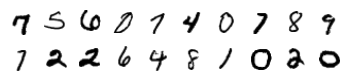

In [6]:
images, labels = next(iter(train_loader))

print(images.shape)
print(labels.shape)

figure = plt.figure()
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### ResNet18 model
This code is taken from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py 

> NOTE: Training uses resnet model as is with addition operation and floating point inputs / outputs.      
But when model is quantized while testing addition operation is replaced with FloatFunction and the inputs         / outputs are quantized/dequantized.

In [7]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding
    
    Args:
        in_planes: number of channels in input image
        out_planes: number of channels produced by convolution
        stride: stride of the convolution. Default: 1
        groups: Number of blocked connections from input channels to output channels. Default: 1
        dilation (int or tuple, optional): Spacing between kernel elements. Default: 1
        
    Returns:
        Convoluted layer of kernel size=3, with specified out_planes
    
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution
    
    Args:
        in_planes: number of channels in input image
        out_planes: number of channels produced by convolution
        stride: stride of the convolution. Default: 1
        
    Returns:
        Convoluted layer of kernel size=1, with specified out_planes
        
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [8]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, quantize=False):
        super(Bottleneck, self).__init__()
        self.quantize = quantize
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # Notice the addition operation in both scenarios
        if self.quantize:
            out = self.skip_add.add(out, identity)
        else:
            out += identity

        out = self.relu(out)

        return out

In [9]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, quantize=False):
        super(BasicBlock, self).__init__()
        self.quantize = quantize
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        # FloatFunction()
        self.skip_add = nn.quantized.FloatFunctional()
        

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # Notice the addition operation in both scenarios
        if self.quantize:
            out = self.skip_add.add(out, identity)
        else:
            out += identity

        out = self.relu(out)

        return out

In [10]:
def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

In [11]:
class ResNet(nn.Module):

    def __init__(self, block=BasicBlock, layers=[2, 2, 2, 2], num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, mnist=False, quantize=False):
        super(ResNet, self).__init__()
        self.quantize = quantize
        if mnist:
            num_channels = 1
        else:
            num_channels = 3
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace 
            # the 2x2 stride with a dilated convolution instead.
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(num_channels, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer, quantize=self.quantize))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer, quantize=self.quantize))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # Input are quantized
        if self.quantize:
            x = self.quant(x)
    
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        # Outputs are dequantized
        if self.quantize:
            x = self.dequant(x)
        
        return x

    def forward(self, x):
         # See note [TorchScript super()]
        return self._forward_impl(x)

### Training the model

In [12]:
def train(args, model, device, train_loader, optimizer, epoch):
    """ Train the model with given dataset
    
    Args:
        args: args like log interval
        model: ResNet model to train
        device: CPU/GPU
        train_loader: dataset iterator
        optimizer: optimizer to update weights
        epoch: number of epochs to train for
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(F.log_softmax(output, dim=-1), target)
        loss.backward()
        optimizer.step()

        if batch_idx % args["log_interval"] == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                datetime.now(),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [13]:
def main_old():
 
    batch_size = 64
    epochs = 5
    lr = 0.01
    momentum = 0.5
    seed = 1
    log_interval = 5
    save_model = True
    no_cuda = False
    
    use_cuda = not no_cuda and torch.cuda.is_available()
    torch.manual_seed(seed)
    device = torch.device("cuda" if use_cuda else "cpu")
    model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=10, mnist=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    args = {}
    args["log_interval"] = log_interval
    for epoch in range(1, epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

# main_old()

In [14]:
def main():
 
    batch_size = 64
    epochs = 1
    lr = 0.01
    momentum = 0.5
    seed = 1
    log_interval = 5
    save_model = True
    no_cuda = False
    
    use_cuda = not no_cuda and torch.cuda.is_available()
    torch.manual_seed(seed)
    device = torch.device("cuda" if use_cuda else "cpu")
    model = ResNet(block=Bottleneck, layers=[3, 4, 6, 3], num_classes=10, mnist=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    args = {}
    args["log_interval"] = log_interval
    for epoch in range(1, epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

# main()

### Testing

In [15]:
def print_size_of_model(model):
    """ Print the size of the model.
    
    Args:
        model: model whose size needs to be determined

    """
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [22]:
def test(model, device, test_loader, quantize=False, fbgemm=False):
    model.to(device)
    model.eval()
    
    # Testing with qauntization if quantize=True
    if quantize:
        modules_to_fuse_old = [['conv1', 'bn1'],
                   ['layer1.0.conv1', 'layer1.0.bn1'],
                   ['layer1.0.conv2', 'layer1.0.bn2'],
                   ['layer1.1.conv1', 'layer1.1.bn1'],
                   ['layer1.1.conv2', 'layer1.1.bn2'],
                   ['layer2.0.conv1', 'layer2.0.bn1'],
                   ['layer2.0.conv2', 'layer2.0.bn2'],
                   ['layer2.0.downsample.0', 'layer2.0.downsample.1'],
                   ['layer2.1.conv1', 'layer2.1.bn1'],
                   ['layer2.1.conv2', 'layer2.1.bn2'],
                   ['layer3.0.conv1', 'layer3.0.bn1'],
                   ['layer3.0.conv2', 'layer3.0.bn2'],
                   ['layer3.0.downsample.0', 'layer3.0.downsample.1'],
                   ['layer3.1.conv1', 'layer3.1.bn1'],
                   ['layer3.1.conv2', 'layer3.1.bn2'],
                   ['layer4.0.conv1', 'layer4.0.bn1'],
                   ['layer4.0.conv2', 'layer4.0.bn2'],
                   ['layer4.0.downsample.0', 'layer4.0.downsample.1'],
                   ['layer4.1.conv1', 'layer4.1.bn1'],
                   ['layer4.1.conv2', 'layer4.1.bn2']]
        model = torch.quantization.fuse_modules(model, modules_to_fuse_old)
        if fbgemm:
            model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        else:
            model.qconfig = torch.quantization.default_qconfig
        torch.quantization.prepare(model, inplace=True)
        model.eval()
        with torch.no_grad():
            for data, target in train_loader:
                model(data)
        torch.quantization.convert(model, inplace=True)

    print(model)
    test_loss = 0
    correct = 0
    index = 0
    with torch.no_grad():
        for data, target in test_loader:
            index += 1
            print(index, datetime.now())
            data, target = data.to(device), target.to(device)
            st = time.time()
            output = model(data)
            et = time.time()
            test_loss += F.nll_loss(F.log_softmax(output, dim=-1), target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print("========================================= PERFORMANCE =============================================")
    print_size_of_model(model)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print('Elapsed time = {:0.4f} milliseconds'.format((et - st) * 1000))
    print("====================================================================================================")

### Baseline performance - unquantized model

In [27]:
device = 'cpu'
encoder = ResNet(num_classes=10, mnist=True)
loaded_dict_enc = torch.load('mnist_cnn-resnet18.pt', map_location=device)
encoder.load_state_dict(loaded_dict_enc)

<All keys matched successfully>

In [28]:
encoder

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05,

In [20]:
test(model=encoder, device=device, test_loader=test_loader)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05,

### Quantization Performance

In [21]:
device = 'cpu'
encoder = ResNet(num_classes=10, mnist=True, quantize=True)
loaded_dict_enc = torch.load('mnist_cnn-resnet18.pt', map_location=device)
encoder.load_state_dict(loaded_dict_enc)
test(model=encoder, device=device, test_loader=test_loader, quantize=True)

ResNet(
  (conv1): QuantizedConv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.12347077578306198, zero_point=61, padding=(3, 3))
  (bn1): Identity()
  (relu): QuantizedReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.10298416018486023, zero_point=60, padding=(1, 1))
      (bn1): Identity()
      (relu): QuantizedReLU(inplace=True)
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.10945683717727661, zero_point=61, padding=(1, 1))
      (bn2): Identity()
      (skip_add): QFunctional(
        scale=0.13676385581493378, zero_point=47
        (activation_post_process): Identity()
      )
    )
    (1): BasicBlock(
      (conv1): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.09816549718379974, zero_point=61, padding=(1, 1))
      (bn1): Identity()
   

In [11]:
16/40

0.4

In [30]:
device = 'cpu'
encoder2 = ResNet(num_classes=10, mnist=True)
loaded_dict_enc = torch.load('mnist_cnn.pt', map_location=device)

In [31]:
encoder2

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05,

In [29]:
encoder2.load_state_dict(loaded_dict_enc)

RuntimeError: Error(s) in loading state_dict for ResNet:
	Unexpected key(s) in state_dict: "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked". 
	size mismatch for layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer1.1.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer2.0.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for layer2.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for layer2.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.1.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for layer3.0.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for layer3.0.downsample.0.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for layer3.0.downsample.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.0.downsample.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.0.downsample.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.0.downsample.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.1.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for layer4.0.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for layer4.0.downsample.0.weight: copying a param with shape torch.Size([2048, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for layer4.0.downsample.1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.0.downsample.1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.0.downsample.1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.0.downsample.1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.1.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for fc.weight: copying a param with shape torch.Size([10, 2048]) from checkpoint, the shape in current model is torch.Size([10, 512]).